In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error

# Matplotlib visual settings
plt.style.use("seaborn-deep")
plt.rcParams['figure.figsize'] = [15,7]

import warnings
warnings.filterwarnings('ignore')

# Wolt 2021 Data Science Internship Assignment

For this assignment I will attempt to develop a time series forecasting model that would enable Wolt to estimate the number of orders for the upcoming week with hourly granularity. Such a successful forecasting model could enable the company to better distribute its resources, and could perhaps be reverse engineered to gain a better understanding of customer behaviour.

# Exploratory Data Analysis

The dataset is missing weather data in some few cases. To mitigate this, we will replace the missing values with the most recent available weather data from before. To simplify analysis, we will round all timestamps in the data by rounding down with hourly accuracy, and then aggregating over the hourly data. Now we are ready to visualize the data!

In [2]:
df = pd.read_csv('orders_autumn_2020.csv')
df.columns = ['timestamp', 'delivery_delay', 'item_count', 'user_lat', 'user_long', 'venue_lat', 'venue_long',
             'delivery_estimate', 'delivery_actual', 'cloud_coverage', 'temperature', 'wind_speed', 'precipitation']

df.timestamp = pd.to_datetime(df.timestamp)
# Round timestamps by taking the floor with respect to the hour
df.timestamp = df.timestamp.apply(lambda x: datetime(x.year, x.month, x.day, x.hour, 0))

In [3]:
# Group by timestamp
gb = df.groupby('timestamp').agg({'timestamp': 'count', 'cloud_coverage': np.mean, 'temperature': np.mean,
                                 'wind_speed': np.mean, 'precipitation': np.mean})
gb.columns = ['orders', 'cloud_coverage', 'temperature', 'wind_speed', 'precipitation']

# Generate all hours from Sept 1 to Aug 30 and join with data
hours = pd.Series(pd.date_range(start=datetime(2020, 8, 1), end=datetime(2020, 9, 30, 23), freq='1H'))
gb = gb.merge(hours.rename('hours'), how='right', left_index=True, right_on='hours')
gb = gb.set_index('hours')

# Replace NaN orders with 0
gb.orders = gb.orders.fillna(0)
# Get latest weather data
gb[['cloud_coverage', 'temperature',
    'wind_speed', 'precipitation']] = gb[['cloud_coverage', 'temperature',
                                          'wind_speed', 'precipitation']].fillna(method='ffill')
# 6 days don't get fixed, so set to 0
gb = gb.fillna(0)

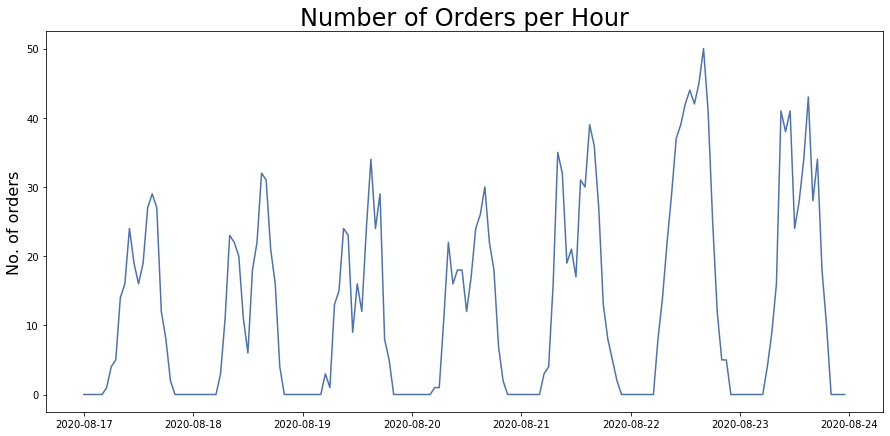

In [4]:
# Beginning of week to display - change this around to investigate different weeks
date = datetime(2020, 8, 17)

temp = gb[(gb.index >= date) & (date + timedelta(days=7) > gb.index)]

plt.plot(temp.index, temp.orders)
plt.title("Number of Orders per Hour", fontsize=24)
plt.ylabel('No. of orders', fontsize=16)
plt.show()

Though this plot, starting at Monday, August 17, only shows one week in the dataset, it displays a pattern that can be observed for most weeks: on a daily basis, there are two distinct peaks in orders, while overall there is a higher volume of orders towards the end of the week.

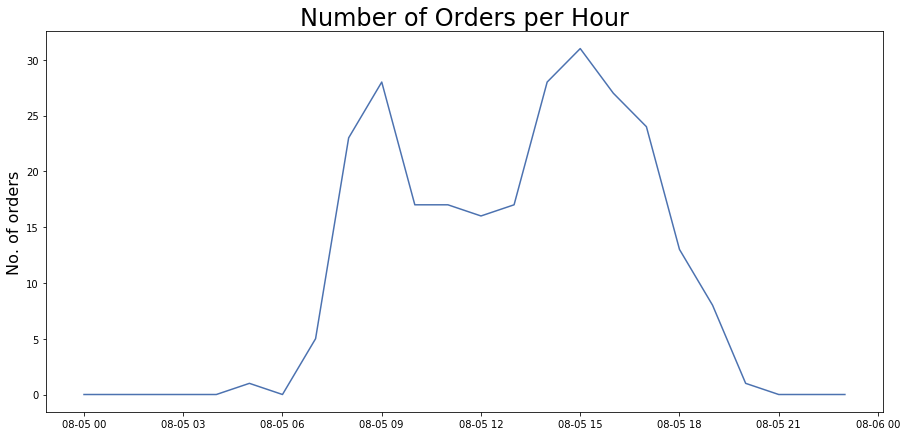

In [5]:
# Day to display
date = datetime(2020, 8, 5)

temp = gb[(gb.index >= date) & (date + timedelta(days=1) > gb.index)]

plt.plot(temp.index, temp.orders)
plt.title("Number of Orders per Hour", fontsize=24)
plt.ylabel('No. of orders', fontsize=16)
plt.show()

Looking more closely at one of the days displaying such bimodality we notice that the two peaks occur at around 9am and 4pm - breakfast and end of the work day.

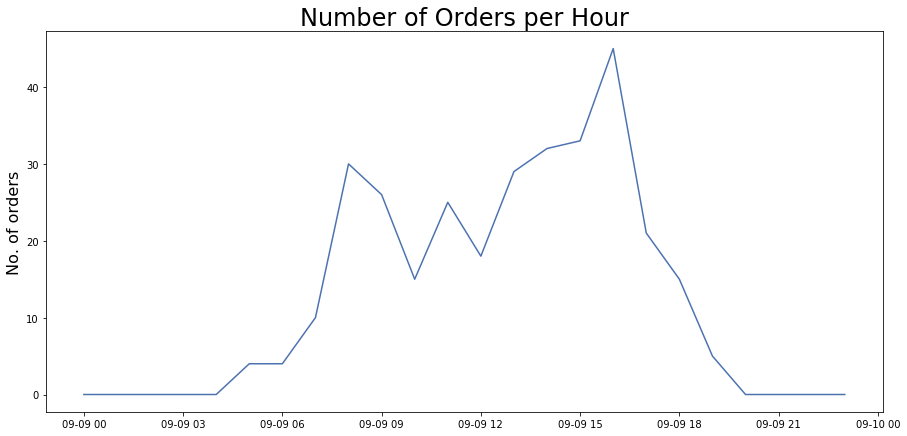

In [6]:
# Day to display
date = datetime(2020, 9, 9)

temp = gb[(gb.index >= date) & (date + timedelta(days=1) > gb.index)]

plt.plot(temp.index, temp.orders)
plt.title("Number of Orders per Hour", fontsize=24)
plt.ylabel('No. of orders', fontsize=16)
plt.show()

What is very interesting, though, is that in many workdays in September there is usually another peak at noon - this is likely an indicator of people returning to work after summer and ordering food for lunch. Eyeballing the data also suggests that there are more orders per day in September vs. August.

# Modeling

We would like for our forecasting model to account for the weekly and daily patterns we observed. A great way to do this is to apply season-trend decomposition to the data, which splits it into a seasonal component, capturing the weekly patterns; a trend component, capturing the general increase in orders from August to September; and a residual component, which captures the noise the two other components fail to account for.

To later evaluate our model we will use the last week's worth of data for testing. We will use the adjustment applied to the second-to-last week in the dataset on the test set as well so that the decomposition process is not biased towards the test set.

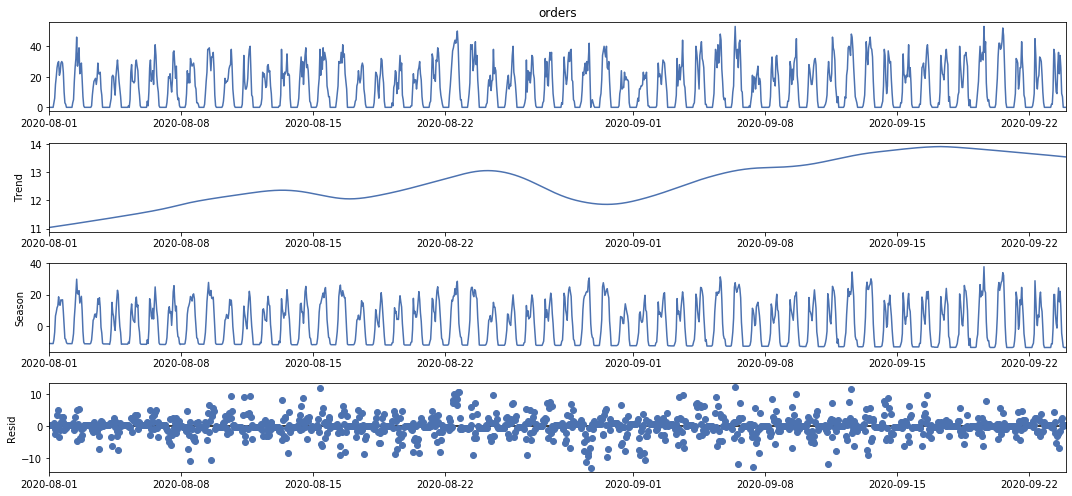

In [7]:
# Use the last week in the dataset for testing
train_data = gb[:-24*7]
test_data = gb[-24*7:]

# period variable set to account for weekly patterns
stl = STL(train_data.orders, period=24*7).fit()

stl.plot()
plt.show()

The above plots show the time series data itself, and the three components created as a result of seasonal-trend decomposition using LOESS smoothing. The trend plot shows that we have successfully captured the general increase in orders over time within the trend component. As the bimodal peaks in the season plot are consistent, it suggests that we have also done a good job capturing the daily and weekly patterns we observed before. The residual plot shows that the residuals are fairly small and constant over time, which means we haven't introduced any great errors into the data with this decomposition.


Now, we can simplify the orders data by subtracting the seasonal trend: this transforms the data to be stationary, i.e. its properties are independent of the time when the data was observed. Stationarity is an assumption of many time series forecasting models and having this property will greatly increase the reliability of our further analysis.

In [8]:
# Use last week in data for testing
train_data['adj_orders'] = train_data.orders - stl.seasonal
# Use most recent week's data to adjust test data
test_data['adj_orders'] = test_data.orders - stl.seasonal[-24*7:].values

A trusty tool to turn to for time series forecasting is ARIMA. It suits our adjusted data really well as one of its core assumptions is stationarity. ARIMA does not require any other data besides the time series data itself for modeling, which is great for the dataset we are working with - we do not really have many variables in our disposal that would help us much with forecasting order volumes.

In [9]:
# Tuning the p, d, q hyperparameters did not really improve the model's performance, the model is great enough
# with them all set to 0
model = ARIMA(train_data.adj_orders).fit()

In [10]:
# Predict and readjust with seasonal component
preds = model.predict(start=test_data.iloc[0].name, end=test_data.iloc[-1].name) + stl.seasonal[-24*7:].values
# Adjusting causes some negative values, so convert them all to 0
preds[preds < 0] = 0

# Evaluation

A simple way to evaluate our model is to compute the root mean squared error for each hour in our test set. That is,

$\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}$

where $y$ is the true number of orders and $\hat{y}$ is the prediction of our model, and we iterate over every hour in the test set. 

Doing so, we obtain the following RMSE:

In [11]:
mean_squared_error(test_data.orders, preds, squared=False)

4.440552558455154

So, on average, the model has an error of 4.44 orders per hour. We can also visualize our predictions vs. the true values over time:

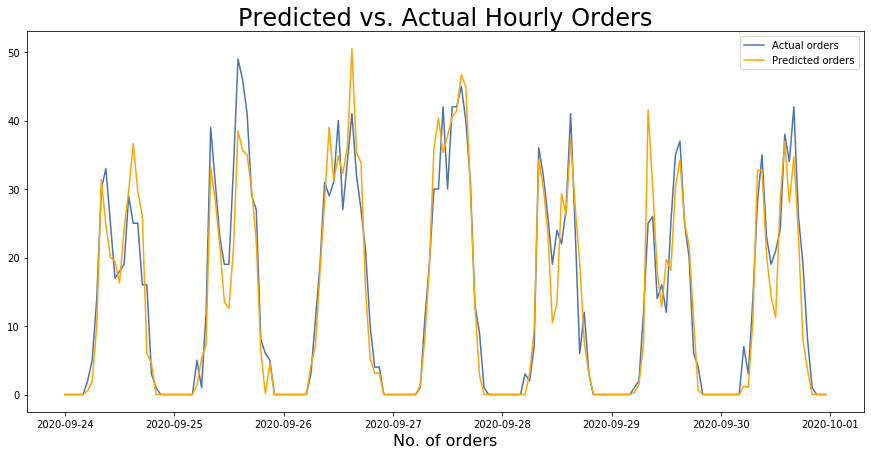

In [12]:
fig, ax = plt.subplots()
ax.plot(test_data.index, test_data.orders, label='Actual orders')
ax.plot(test_data.index, preds, label='Predicted orders', color='orange')

plt.title("Predicted vs. Actual Hourly Orders", fontsize=24)
plt.xlabel('No. of orders', fontsize=16)
plt.legend()
plt.show()

This plot is really encouraging: the model perfectly captures the fact that there are no orders during night time, and its predictions clearly follow the bimodal pattern. It should also be noted that this time series starts on Thursday, September 24, so the model does a good job predicting the greater volumes on the weekend of September 26-27, but falls a bit short on the preceding Friday. It appears that the greatest cause of error is failing to predict the number of orders during peak hours, which have a lot of volatility.

# What's next?

I am already very pleased with the results of the modeling. The methodology implemented is quite simple and makes few assumptions, yet it performs pretty well. We can increase the complexity of the analysis by trying to use a more complicated model.

Our current model uses only the information contained in the time series itself, but there are a couple of variables we would expect to benefit our predictions, namely the weather data. We can expect rainy days to invite more people to stay at home and order in, but also warm summer days to invite people to enjoy their day with a delicious meal.

In [13]:
model = ARIMA(train_data.adj_orders,
              exog=train_data[['cloud_coverage', 'temperature', 'wind_speed', 'precipitation']]).fit()

# Predict and readjust with seasonal component
preds = model.predict(start=test_data.iloc[0].name,
                      end=test_data.iloc[-1].name,
                      exog=test_data[['cloud_coverage', 'temperature',
                                       'wind_speed', 'precipitation']]) + stl.seasonal[-24*7:].values
# Adjusting causes some negative values, so convert them all to 0
preds[preds < 0] = 0

Again, we can compute the RMSE and plot the true values against the predicted ones:

In [14]:
mean_squared_error(test_data.orders, preds, squared=False)

4.418196854271532

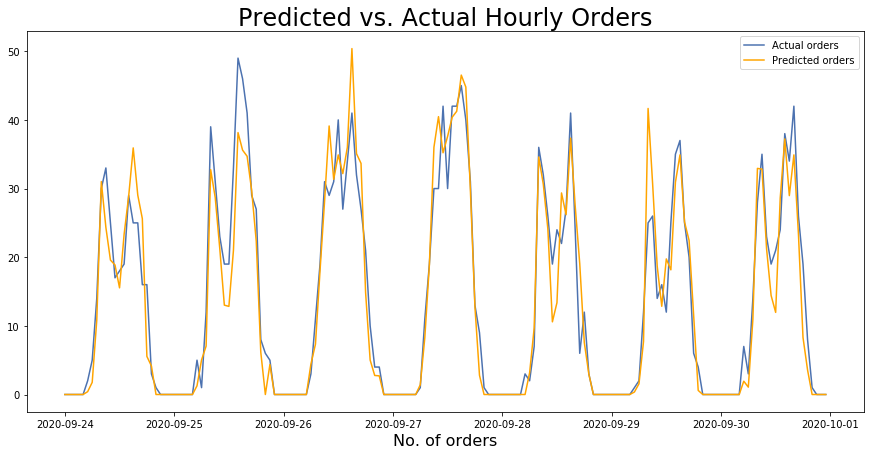

In [15]:
fig, ax = plt.subplots()
ax.plot(test_data.index, test_data.orders, label='Actual orders')
ax.plot(test_data.index, preds, label='Predicted orders', color='orange')

plt.title("Predicted vs. Actual Hourly Orders", fontsize=24)
plt.xlabel('No. of orders', fontsize=16)
plt.legend()
plt.show()

In terms of RMSE, we see the slightest improvement to our predictions, but visually not much has changed. Still, it is encouraging in terms of telling what the next step should be for more accurate predictions: get more data!

There are likely many latent variables that affect if and when customers decide to order food via Wolt, but most of that information is not present in this small dataset. The results of these simple models are already very impressive, so squeezing every bit of information into the models could produce exceptionally precise results.

I don't have many good guesses for what information should be added. Instead, if I was actually a data scientist at Wolt, I would love the opportunity to chat with my colleagues who are domain experts and would likely immediately come up with ideas for what sort of data to look for.